In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import decoding_analysis_vis as dav
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import xarray as xr
sns.set_palette('colorblind')

In [12]:
AllSesDict = {xx: dav.AllSessions(memory_efficient=True, sess_type=xx) for xx in ['sens', 'proj']}

session name : 2020-09-04_RL093.pkl
Excluded 302 out of 2097 neurons
session name : 2020-09-08_RL099.pkl
Excluded 276 out of 2095 neurons
session name : 2020-09-14_RL101.pkl
Excluded 602 out of 2169 neurons
session name : 2020-09-16_RL103.pkl
Excluded 461 out of 2106 neurons
session name : 2020-10-02_RL108.pkl
Excluded 969 out of 2563 neurons
session name : 2020-10-12_RL109.pkl
Excluded 843 out of 2515 neurons
Individual sessions loaded
session name : 2021-02-18_RL127.pkl
Excluded 833 out of 2334 neurons
session name : 2021-02-22_RL128.pkl
Excluded 893 out of 2308 neurons
session name : 2021-02-23_RL129.pkl
Excluded 1323 out of 2364 neurons
session name : 2021-02-24_RL132.pkl
Excluded 757 out of 2156 neurons
session name : 2021-02-25_RL131.pkl
Excluded 1361 out of 2448 neurons
session name : 2021-03-02_RL130.pkl
Excluded 518 out of 2258 neurons
Individual sessions loaded


In [11]:
tmp = dav.SimpleSession(verbose=1, session_id=0, sess_type='proj',
                        shuffle_trial_labels=False,
                        shuffle_timepoints=False,
                        shuffle_all_data=False,
                        prestim_baseline=False,
                        bool_filter_neurons=True)

# tmp = None                        

session name : 2021-02-18_RL127.pkl
Excluded 833 out of 2334 neurons


In [10]:
np.where(tmp.full_ds.activity.mean(['neuron', 'trial']) == 0)[0]

array([31, 32, 33, 34])

In [29]:
# tmpr = tmp.dataset_selector(region='s1', min_t=-0.9, max_t=1.9, trial_type_list=['sensory', 'random'], 
#                             deepcopy=True, remove_added_dimensions=True)  
tmpr = tmp.dataset_selector(region='s1', frame_id=78, trial_type_list=['sensory', 'random'], 
                            deepcopy=True, remove_added_dimensions=True)  


In [53]:
np.where(AllSesDict['proj'].full_ds.artefact_bool)[0][-1] + 1

35

In [54]:
tt_list_dict = {'sens': ['sham', 'sensory', 'random'],
                'proj': ['sham', 'projecting', 'non_projecting']}

selected_data_dict = {}
p_val_super_dict = {}
for xx in ['sens', 'proj']:
    for reg in ['s1', 's2']:
        print(f'Now selecting {xx} in {reg}')
        selected_data_dict[f'{xx}_{reg}'] = AllSesDict[xx].dataset_selector(AllSesDict[xx], region=reg, min_t=-2, max_t=6, 
                                                                        trial_type_list=tt_list_dict[xx],
                                                                        exclude_targets_s1=True)
        _, p_val_super_dict[f'{xx}_{reg}'] = dav.compute_dynamic_pvals(ds=selected_data_dict[f'{xx}_{reg}'], 
                                                                        tt_list=tt_list_dict[xx],  
                                                                        first_frame=np.where(AllSesDict[xx].full_ds.artefact_bool)[0][-1] + 1)  # first post-stim dp
                                                                        # first_frame=selected_data_dict[f'{xx}_{reg}'].frame_array.data[0])  # first dp

Now selecting sens in s1
sham_sensory
sham_random
sensory_random
Now selecting sens in s2
sham_sensory
sham_random
sensory_random
Now selecting proj in s1
sham_projecting
sham_non_projecting
projecting_non_projecting
Now selecting proj in s2
sham_projecting
sham_non_projecting
projecting_non_projecting


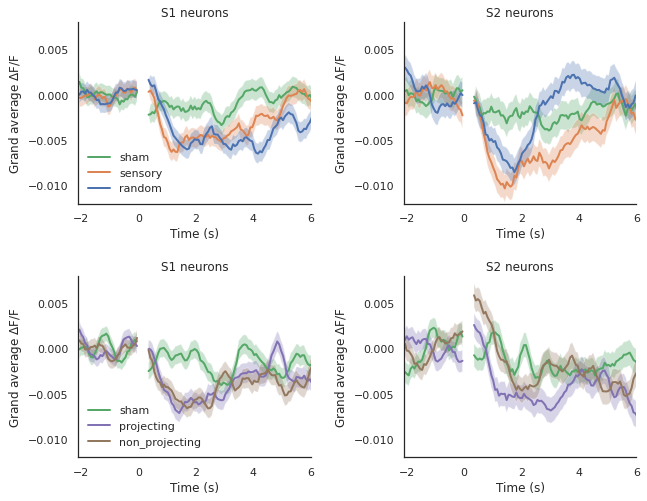

In [43]:
fig, ax_av = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})


for i_xx, xx in enumerate(['sens', 'proj']):
    for i_reg, reg in enumerate(['s1', 's2']):
        curr_ax = ax_av[i_xx, i_reg]
        dav.plot_grand_average(ds=selected_data_dict[f'{xx}_{reg}'], ax=curr_ax, smooth_mean=True,
                               tt_list=tt_list_dict[xx], plot_legend=(reg == 's1'),
                               plot_significance=False)
        curr_ax.set_title(f'{reg.upper()} neurons')
        curr_ax.set_xlim([-2.1, 6])

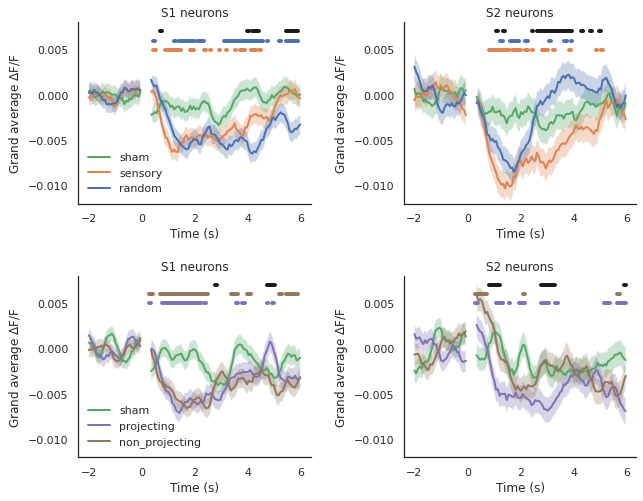

In [59]:
fig, ax_av = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})


for i_xx, xx in enumerate(['sens', 'proj']):
    for i_reg, reg in enumerate(['s1', 's2']):
        curr_ax = ax_av[i_xx, i_reg]
        dav.plot_grand_average(ds=selected_data_dict[f'{xx}_{reg}'], ax=curr_ax, smooth_mean=True,
                               tt_list=tt_list_dict[xx], plot_legend=(reg == 's1'),
                                plot_significance=True, test_method='uncorrected', 
                                p_val_dict=p_val_super_dict[f'{xx}_{reg}'],
                                first_frame_significance=np.where(AllSesDict[xx].full_ds.artefact_bool)[0][-1] + 1)  # first post-stim dp
                                # first_frame_significance=selected_data_dict[f'{xx}_{reg}'].frame_array.data[0])
        curr_ax.set_title(f'{reg.upper()} neurons')
        # curr_ax.set_xlim([-2.1, 6])

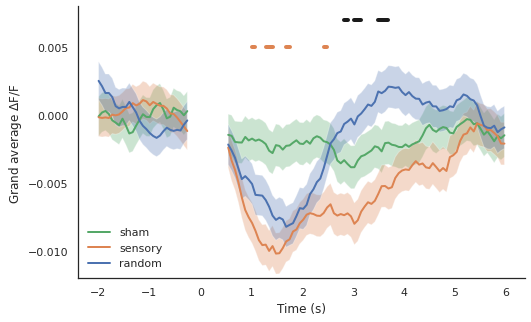

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx = 'sens'
reg = 's2'
dav.plot_grand_average(ds=selected_data_dict[f'{xx}_{reg}'], ax=ax, smooth_mean=True,
                       tt_list=tt_list_dict[xx], plot_legend=True,
                       plot_significance=True, test_method='holm_bonferroni', 
                       p_val_dict=p_val_super_dict[f'{xx}_{reg}'])

In [35]:
bonf_dict = dav.bonferroni_correction(p_val_dict=p_val_super_dict[f'{xx}_{reg}'])
holm_bonf_dict = dav.holm_bonferroni_correction(p_val_dict=p_val_super_dict[f'{xx}_{reg}'])
cluster_size_dict = dav.suprathreshold_cluster_size_test(p_val_dict=p_val_super_dict[f'{xx}_{reg}'])
time_array = selected_data_dict[f'{xx}_{reg}'].time.where(selected_data_dict[f'{xx}_{reg}'].frame_array >= 37, drop=True).data


sizes greater than th:  9.0 [ 1 12  6  3  2  1  4  2  1  2  1  1  2  2  1  1] [False  True False False False False False False False False False False
 False False False False]
sizes greater than th:  6.0 [1 1 1 3 1 6 3 1 1 2 1 3 2 1 1 1] [False False False False False  True False False False False False False
 False False False False]
sizes greater than th:  8.0 [ 2  2  1  1  1  2 21  1  2  1  2  1  2  1] [False False False False False False  True False False False False False
 False False]


In [49]:
bonf_dict.keys()

dict_keys(['sham_sensory', 'sham_random', 'sensory_random'])

In [44]:
cluster_size_dict

{'sham_sensory': array([False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 'sham_random': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, 